In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import librosa
import librosa.display
import torch.optim as optim
import os
from scipy.io import wavfile
import sys
from sklearn.model_selection import train_test_split
import random

In [ ]:
def addRandomNoise(labels,audioFiles,noiseLevelDB=-40):
    data=[]
    labelsNoisy=[]
    gain = 10**(noiseLevelDB / 20)
    for i,x in enumerate(audioFiles):
        num_samples=len(x)
        x2=x+ (np.random.normal(0, 1, size=num_samples)*random.uniform(0,gain))
        data.append(x2)
        labelsNoisy.append(labels[i])

    return labelsNoisy,data

def readAndSegmentFiles(directories, windowSize, noiseLevelDB=-40,addNoise=True):
    ytemp = []
    N = []
    ytraintemp = []
    Ntrain = []

    base_path = 'sounds'

    for directory in directories:
        directory_path = os.path.join(base_path, directory)


        files = os.listdir(directory_path)

        for filename in files:
            file_path = os.path.join(directory_path, filename)

            audio_data, sample_rate = librosa.load(file_path, sr=8000)

            N.append(audio_data)
            ytemp.append(directories.index(directory))

    samplePerSegment = int(sample_rate * windowSize)
    audioSegments = []
    y = []

    for idt in range(len(N)):
        track = N[idt]
        for i in range(0, len(track), samplePerSegment):
            if i + samplePerSegment <= len(track):
                audioSegments.append(track[i:i+samplePerSegment])
                y.append(ytemp[idt])

    if addNoise:
      y, audioSegments = addRandomNoise(y, audioSegments, noiseLevelDB)

    X_train, X_test, y_train, y_test = train_test_split(audioSegments, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, y_train, X_test, y_test


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LSTMNetwork(nn.Module):
    def __init__(self, input_size=96, hidden_size=50, num_classes=5):
        super(LSTMNetwork, self).__init__()

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=input_size, batch_first=True,num_layers=2)

        self.fc1 = nn.Linear(input_size, input_size)

        self.fc2 = nn.Linear(input_size, hidden_size)

        self.output = nn.Linear(hidden_size , num_classes)

    def forward(self, x):
        lstm_out, (hn1, cn) = self.lstm1(x)
        # Take the output from the last time step (hn is the hidden state at the last time step)
        x=lstm_out[:, -1, :]

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        x = self.output(x)

        return x



In [ ]:
directories = ["N","AS","MR","MS","MVP"]
audioSegments,y,audioSegmentsTest,yTest=readAndSegmentFiles(directories,1,-22,False)

log_mel_spectrogram_list = []
log_mel_spectrogram_list_test=[]
for track in audioSegments:
    mel_spectrogram = librosa.feature.melspectrogram(y=track, sr=8000, n_fft=256, hop_length=128, n_mels=96)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    log_mel_spectrogram_list.append(log_mel_spectrogram)

for track in audioSegmentsTest:
    mel_spectrogram = librosa.feature.melspectrogram(y=track, sr=8000, n_fft=256, hop_length=128, n_mels=96)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    log_mel_spectrogram_list_test.append(log_mel_spectrogram)



In [ ]:
all_specs = np.concatenate(log_mel_spectrogram_list, axis=1)
mean = np.mean(all_specs)
std = np.std(all_specs)

log_mel_spectrogram_list = [(spec - mean) / std for spec in log_mel_spectrogram_list]
log_mel_spectrogram_list_test = [(spec - mean) / std for spec in log_mel_spectrogram_list_test]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
data = torch.tensor(log_mel_spectrogram_list, dtype=torch.float32)
data=data.transpose(1,2)
print("Data shape:", data.shape)
y = torch.tensor(y, dtype=torch.long)
print("label shape:", y.shape)
train_data = TensorDataset(data, y)
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
model = LSTMNetwork(input_size=96, num_classes=len(directories)).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000002)

<ipython-input-9-d2d071c73482>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  data = torch.tensor(log_mel_spectrogram_list, dtype=torch.float32)


Data shape: torch.Size([1604, 63, 96])
label shape: torch.Size([1604])


In [ ]:

num_epochs = 2000

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/2000], Loss: 1.6099
Epoch [2/2000], Loss: 1.6102
Epoch [3/2000], Loss: 1.6100
Epoch [4/2000], Loss: 1.6092
Epoch [5/2000], Loss: 1.6091
Epoch [6/2000], Loss: 1.6091
Epoch [7/2000], Loss: 1.6092
Epoch [8/2000], Loss: 1.6082
Epoch [9/2000], Loss: 1.6079
Epoch [10/2000], Loss: 1.6083
Epoch [11/2000], Loss: 1.6074
Epoch [12/2000], Loss: 1.6081
Epoch [13/2000], Loss: 1.6069
Epoch [14/2000], Loss: 1.6072
Epoch [15/2000], Loss: 1.6072
Epoch [16/2000], Loss: 1.6062
Epoch [17/2000], Loss: 1.6055
Epoch [18/2000], Loss: 1.6060
Epoch [19/2000], Loss: 1.6059
Epoch [20/2000], Loss: 1.6055
Epoch [21/2000], Loss: 1.6058
Epoch [22/2000], Loss: 1.6046
Epoch [23/2000], Loss: 1.6046
Epoch [24/2000], Loss: 1.6044
Epoch [25/2000], Loss: 1.6042
Epoch [26/2000], Loss: 1.6037
Epoch [27/2000], Loss: 1.6033
Epoch [28/2000], Loss: 1.6031
Epoch [29/2000], Loss: 1.6031
Epoch [30/2000], Loss: 1.6025
Epoch [31/2000], Loss: 1.6017
Epoch [32/2000], Loss: 1.6017
Epoch [33/2000], Loss: 1.6012
Epoch [34/2000], Lo

In [ ]:
import time
allPrededicted=[]
allReal=[]
maxTime=0

for x in range(len(log_mel_spectrogram_list_test)):
    example = torch.tensor(log_mel_spectrogram_list_test[x], dtype=torch.float32).unsqueeze(0)
    example=example.transpose(1,2)
    model.eval()

    start_time = time.perf_counter()
    with torch.no_grad():
        example=example.to(device)
        output = model(example)
    end_time = time.perf_counter()
    maxTime=max(maxTime,end_time-start_time)

    predicted_class = torch.argmax(output, dim=1).item()
    real_class = yTest[x]
    allPrededicted.append(predicted_class)
    allReal.append(real_class)

In [ ]:
correct=0
wrong=0
for x in range(len(allPrededicted)):
    if allPrededicted[x]==allReal[x]:
        correct=correct+1
    else:
        wrong=wrong+1

print(f'Correct: {correct}')
print(f'Wrong: {wrong}')

Correct: 396
Wrong: 5


Accuracy: 0.9875311720698254
Precision: 0.9878572045238713
Recall: 0.9872102897102897
F1 Score: 0.9874085153958362
Accuracy: 0.9875311720698254


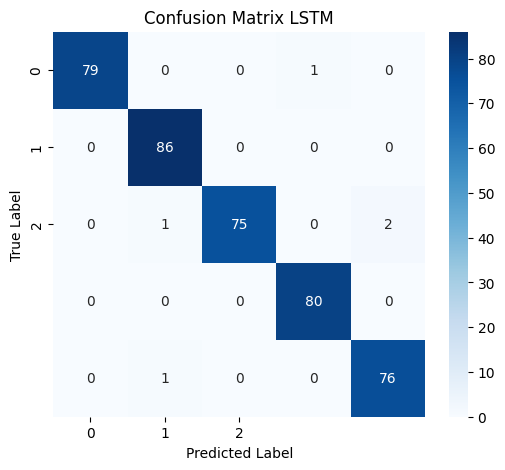

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(allReal,allPrededicted)
precision = precision_score(allReal,allPrededicted,average='macro')
recall = recall_score(allReal,allPrededicted,average='macro')
f1 = f1_score(allReal,allPrededicted,average='macro')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)
cm=confusion_matrix(allReal,allPrededicted)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix LSTM")
plt.show()
